In [1]:
from brian2 import *
from brian2tools import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


from plotting_helper import * 


figures_path = 'figures/'
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']  


In [2]:
VDP_eq = '''
    dglutamate/dt = - glutamate/tau_glutamate : 1 (clock-driven)
    sig_LTP = 1/(1+exp(k_LTP*(-(v - theta_NMDA)+0*mV))) : 1 (constant over dt)
    dv_NMDA_rise/dt = (-v_NMDA_rise + clip(clip(sig_LTP - v_NMDA,0,100) - v_NMDA_rise,0,100))/tau_NMDA_rise : 1 (clock-driven)             
    dv_NMDA/dt = (NMDA_amp * v_NMDA_rise - v_NMDA)/tau_NMDA_fall : 1 (clock-driven)
    sig_LTD = 1/(1+exp(k_LTD*(-(v - theta_VDCC)+0*mV))) : 1 (constant over dt)
    dVDCC_rise/dt = (-VDCC_rise + clip(clip(sig_LTD - VDCC,0,100) -VDCC_rise, 0, 100))/tau_VDCC_rise : 1 (clock-driven) 
    dVDCC/dt = (VDCC_amp * VDCC_rise - VDCC) * 1/tau_VDCC_fall : 1 (clock-driven)
    Ca = VDCC**(exp(-c_ca)*20) + v_NMDA**(exp(-c_ca)*20) * int(glutamate>0) : 1 (constant over dt)
    dw/dt = clip(eta * Ca  * (v_NMDA * LTP_amp - VDCC * LTD_amp) * glutamate/tau_w*dt,(wmin-w),(wmax-w))/dt : 1 (clock-driven)
    tau_glutamate :second
    theta_NMDA : volt
    tau_NMDA_rise : second
    tau_NMDA_fall : second
    NMDA_amp : 1
    theta_VDCC : volt
    tau_VDCC_rise : second
    tau_VDCC_fall : second
    VDCC_amp : 1
    k_LTP : 1/volt
    k_LTD : 1/volt
    LTP_amp : 1
    LTD_amp : 1
    Apre : 1  #this is technically decided by tau_glutamate but just adding it here for completeness sake
    eta : 1
'''

#no homeostatic compensation here
clopath_eq = '''
    dvp/dt = (-vp + v)/tau_p : volt (clock-driven)
    dvm/dt = (-vm + v)/tau_m : volt (clock-driven)
    ds/dt = -s/tau_s : 1 (clock-driven)
    dw/dt = eta * A_p  * (v - theta_p)/mV * int((v - theta_p)/mV > 0 ) * (vp - theta_m)/mV*int((vp - theta_m)/mV > 0 ) * s / tau_w : 1 (clock-driven)
    tau_p : second
    tau_m : second
    tau_s : second
    A_p : 1
    A_d : 1
    theta_p : volt
    theta_m : volt
    g : 1
    eta : 1

'''
on_pre_cl = '''s += g
            w -= eta * 0.1 * A_d *(vm - theta_m)/mV * int((vm - theta_m)/mV > 0)'''

meissner_bernard_eq = '''
    dvp/dt = (-vp + v)/tau_p : volt (clock-driven)
    dvm/dt = (-vm + v)/tau_m : volt (clock-driven)
    ds/dt = -s/tau_s : 1 (clock-driven)
    dw/dt = clip(eta * (A_p  * (vp - theta_p)/mV*int((vp - theta_p)/mV > 0 ) - A_d *(vm - theta_m)/mV * int((vm - theta_m)/mV > 0)) * s /tau_w * dt, (wmin - w), (wmax-w))/dt : 1 (clock-driven)
    tau_p : second
    tau_m : second
    tau_s : second
    A_p : 1
    A_d : 1
    theta_p : volt
    theta_m : volt
    g : 1
    eta : 1

'''



on_pre_mb = '''
    s += g'''

passive = '''
    dv/dt =  (vrest-v)/tau + n_sigma*xi*tau**-0.5: volt
    tau : second
    tau_n : second
    n_sigma : volt
'''

act_offset = 0
tau_Ca = 1 * ms
c_ca = 3.0
tau_w = 1 * ms

vrest = -79 * mV
wmin = 0
wmax = 10

In [3]:
def unpack_VDP_params(Syn, params):
    
    Syn.Apre = params[0] 
    Syn.tau_glutamate = params[1] *ms
    
    Syn.k_LTD = params[2] /mV 
    LTD_rise = params[3]
    LTD_fall = params[4]
    LTP_rise = params[8]
    LTP_fall = params[9]
    Syn.tau_VDCC_rise = LTD_rise * ms
    Syn.tau_VDCC_fall = LTD_fall * ms
    Syn.theta_VDCC  = params[5] * mV
    Syn.LTD_amp = params[6]
    
    Syn.k_LTP = params[7] / mV
    Syn.tau_NMDA_rise = LTP_rise * ms
    Syn.tau_NMDA_fall =  LTP_fall * ms
    Syn.theta_NMDA = params[10] * mV
    Syn.LTP_amp = params[11]
    Syn.eta = params[12]

    
    #predetermined by time constants
    Syn.NMDA_amp = (LTP_rise/LTP_fall)**(LTP_fall/(LTP_rise - LTP_fall))
    Syn.VDCC_amp = (LTD_rise/LTD_fall)**(LTD_fall/(LTD_rise - LTD_fall))

    return Syn


def unpack_clopath_params(Syn, params):
    
    Syn.g = params[0] 
    Syn.tau_s = params[1] *ms
    
    Syn.tau_m = params[2] *ms
    Syn.tau_p = params[3] * ms
    Syn.A_d = params[4]
    Syn.A_p = params[5]
    Syn.theta_m = params[6] *mV
    Syn.theta_p = params[7] * mV
    Syn.eta = params[8]
    
    return Syn

def run_subthreshold_dyn(sigma, tau, sim_time, runs, w0): 
    
    start_scope()
    seed(42)
    
    GE = NeuronGroup(runs, passive, method='euler')
    GE.tau = tau *ms
    GE.n_sigma = sigma *mV
    
    GE.v = vrest
    
    pre_spikes = np.arange(0,sim_time, 100) #in ms, 10Hz
    
    pre = SpikeGeneratorGroup(1, np.zeros([pre_spikes.shape[0]]), pre_spikes*ms)
    
    S_VDP = Synapses(pre, GE, VDP_eq,
             on_pre='''
             glutamate += Apre
             ''', method='euler')
    S_VDP.connect(p=1)
    
    S_VDP = unpack_VDP_params(S_VDP, vdp_params)
    S_VDP.w = w0
    
    S_clopath = Synapses(pre, GE, clopath_eq,
             on_pre=on_pre_cl, method='euler')
    S_clopath.connect(p=1)
    S_clopath = unpack_clopath_params(S_clopath, cl_params)
    S_clopath.w = w0
    #initialis the v+ and v_
    S_clopath.vp = vrest
    S_clopath.vm = vrest
    
    S_mb = Synapses(pre, GE, meissner_bernard_eq,
             on_pre=on_pre_mb, method='euler')
    S_mb.connect(p=1)
    S_mb = unpack_clopath_params(S_mb, mb_params) #same function, does not need to be changed
    S_mb.w = w0
    #initialis the v+ and v_
    S_mb.vp = vrest
    S_mb.vm = vrest
    
    v_mon = StateMonitor(GE, ['v'], record = np.array([0]), dt = 1 * ms)
    
    net = Network(GE, pre, S_VDP, S_clopath, v_mon, S_mb)
    net.run(sim_time*ms)
    
    
    return np.array([np.mean((S_VDP.w-w0)/w0 * 100 + 100), np.std((S_VDP.w-w0)/w0 * 100 + 100)]), np.array([np.mean((S_clopath.w-w0)/w0 * 100 + 100), np.std((S_clopath.w-w0)/w0 * 100 + 100)]), np.array([np.mean((S_mb.w-w0)/w0 * 100 + 100), np.std((S_mb.w-w0)/w0 * 100 + 100)]), v_mon.v





In [4]:
cl_params = [1/15, 15, 10,7, 12.e-3, 8.e-5,-61, -58,1]

vdp_params = [0.1, 10, 0.4, 1, 20, -43.75, 0.5, 0.4, 1, 5, -40.75, 1.0, 0.1]

mb_params = [1/15, 15, 10,7, 6.e-3, 8e-3,-61, -58,1] 

sim_time = 10000  #10s
runs = 100
w0 = 1
tau_w = 1 * ms

sigmas = np.linspace(5,35,10)
taus = np.array([1,10,50])

cl_results = np.zeros([taus.shape[0], sigmas.shape[0],2])
vdp_results = np.zeros([taus.shape[0], sigmas.shape[0],2])
mb_results = np.zeros([taus.shape[0], sigmas.shape[0],2])

v_example = []

for i in range(taus.shape[0]): 
    for j in range(sigmas.shape[0]): 
        vdp_results[i,j], cl_results[i,j], mb_results[i,j], v_exam = run_subthreshold_dyn(sigmas[j], taus[i], sim_time, runs, w0)
    v_example.append(v_exam)
    

INFO:root:creating /tmp/brian_flag_test_0vw8r_h_/tmp
INFO:root:creating /tmp/brian_flag_test_0vw8r_h_/tmp/brian_flag_test_0vw8r_h_
INFO:root:gcc -pthread -B /disk/scratch/prubisch/miniconda/envs/brian_env/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -c /tmp/brian_flag_test_0vw8r_h_/flag_test.cpp -o /tmp/brian_flag_test_0vw8r_h_/tmp/brian_flag_test_0vw8r_h_/flag_test.o -w
INFO:root:creating /tmp/brian_flag_test_h5krbfsh/tmp
INFO:root:creating /tmp/brian_flag_test_h5krbfsh/tmp/brian_flag_test_h5krbfsh
INFO:root:gcc -pthread -B /disk/scratch/prubisch/miniconda/envs/brian_env/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -c /tmp/brian_flag_test_h5krbfsh/flag_test.cpp -o /tmp/brian_flag_test_h5krbfsh/tmp/brian_flag_test_h5krbfsh/flag_test.o -O3
INFO:root:creating /tmp/brian_flag_test_0kbmc50c/tmp
INFO:root:creating /tmp/brian_flag_test_0kbmc50c/tmp/brian_flag_test_0kbmc50c
INFO

INFO:root:building '_cython_magic_6fca0c7431b70fe287e9ae1b3c102eab' extension
INFO:root:gcc -pthread -B /disk/scratch/prubisch/miniconda/envs/brian_env/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/disk/scratch/prubisch/miniconda/envs/brian_env/include -I/afs/inf.ed.ac.uk/user/s15/s1576881/.local/lib/python3.8/site-packages/numpy/core/include -I/afs/inf.ed.ac.uk/user/s15/s1576881/.local/lib/python3.8/site-packages/brian2/synapses -I/disk/scratch/prubisch/miniconda/envs/brian_env/include/python3.8 -c /afs/inf.ed.ac.uk/user/s15/s1576881/.cython/brian_extensions/_cython_magic_6fca0c7431b70fe287e9ae1b3c102eab.cpp -o /afs/inf.ed.ac.uk/user/s15/s1576881/.cython/brian_extensions/afs/inf.ed.ac.uk/user/s15/s1576881/.cython/brian_extensions/_cython_magic_6fca0c7431b70fe287e9ae1b3c102eab.o -w -O3 -ffast-math -fno-finite-math-only -march=native -std=c++11
INFO:root:g++ -pthread -B /disk/scratch/prubisch/miniconda/envs/brian_env/compiler_c

WARNING    'tau' is an internal variable of group 'neurongroup_6', but also exists in the run namespace with the value 50. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 50. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 50. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value 50. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau' is an internal variable of group 'neurongroup_3', but also exists in the run namespace with the value 50. The internal variab

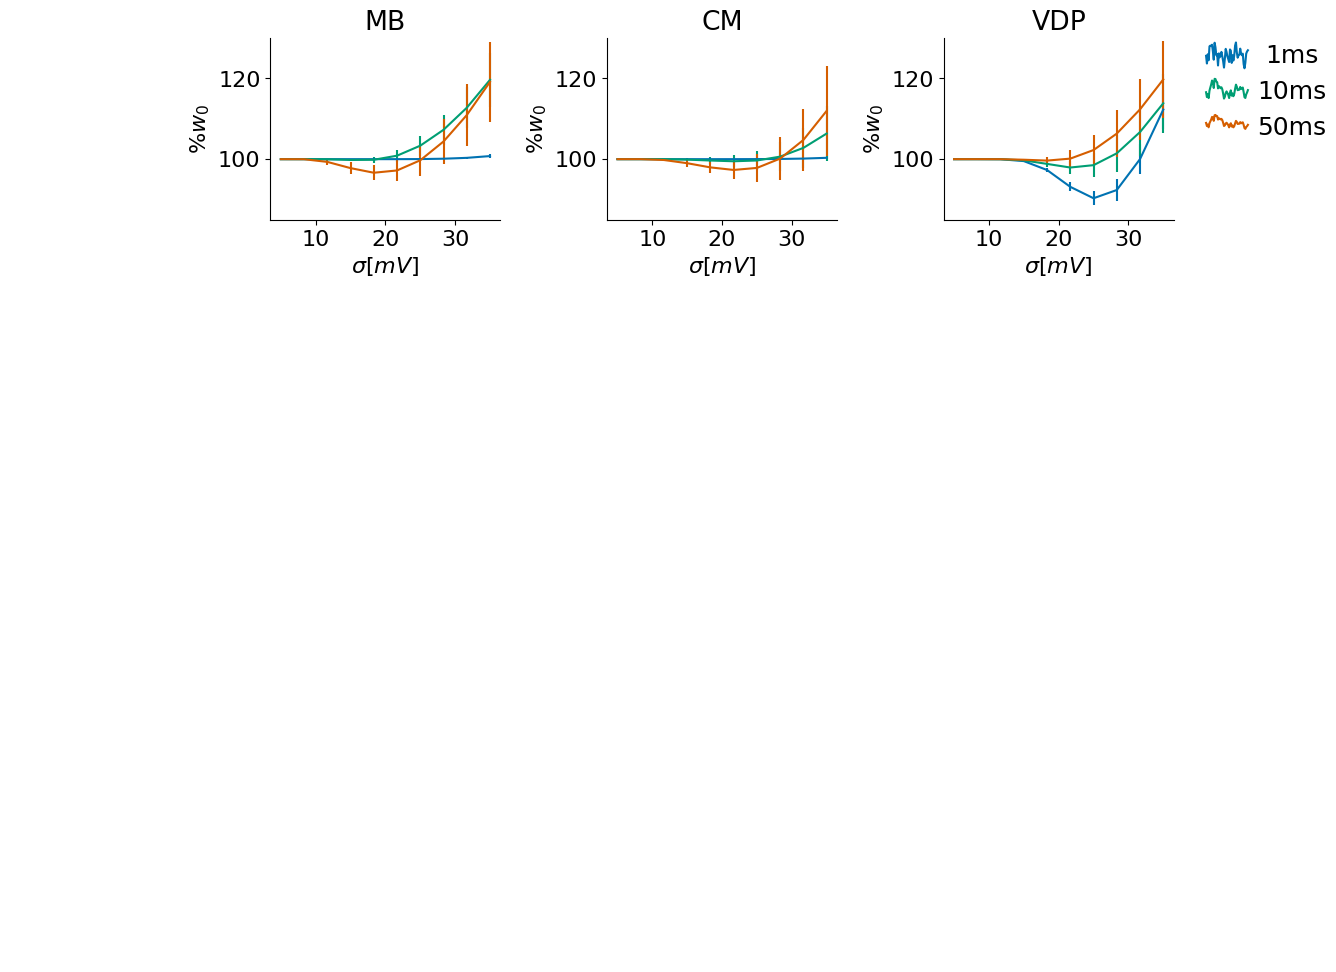

In [9]:

layout = '''
    ABBCCDD
    ABBCCDD
    ABBCCDD
    ABBCCDD
    ABBCCDD
    '''

fig = plt.figure(figsize=(16, 12))

height_ratios = [1,0.05,1, 0.05,1]
width_ratios = [1,1,0.2,1,0.2,1,0.2]

specs, gs = panel_specs(layout, fig=fig)
gs.set_height_ratios(height_ratios)
gs.set_width_ratios(width_ratios)
gs.hspace=0.8
axes = {}
for letter in 'ABCD':
    axes[letter] = ax = fig.add_subplot(specs[letter])
#label_panels(axes, letters='ABC', postfix='', offset_left=1.2)
for a in list('ABCD'):
    axes[a].set_axis_off()
    

#plot for A
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']  
ax = fig.add_subplot(gs[0,5])
for i in range(taus.shape[0]):
    ax.errorbar(sigmas, vdp_results[i,:,0], yerr = vdp_results[i,:,1])
ax.set_ylabel('$\% w_0$')
ax.set_xlabel('$\sigma[mV]$')
ax.set_title('VDP')
ax.set_ylim(85,130)
clear_axes(ax)


#add a costum legend with examples of the process
ax = fig.add_subplot(gs[0,6])
fromt = 100
tot = 150
for i in range(taus.shape[0]):
    normed_v_ex = v_example[i][0,fromt:tot]/ np.max(np.abs(v_example[i][0,fromt:tot]))
    ax.plot(normed_v_ex*0.5 +(3-i*0.5) )

    ax.text(100, (2.6-i*0.6), str(taus[i])+'ms', fontsize =18, ha='center')
ax.set_ylim(-0.0,3)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False) 
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
clear_axes(ax)


#plot for B
ax = fig.add_subplot(gs[0,3])
for i in range(taus.shape[0]):
    ax.errorbar(sigmas, cl_results[i,:,0], yerr = cl_results[i,:,1], label = taus[i])
ax.set_ylabel('$\% w_0$')
ax.set_xlabel('$\sigma[mV]$')
ax.set_title('CM')
ax.set_ylim(85,130)
clear_axes(ax)

ax = fig.add_subplot(gs[0,1])
for i in range(taus.shape[0]):
    ax.errorbar(sigmas, mb_results[i,:,0], yerr = mb_results[i,:,1], label = taus[i])
ax.set_ylabel('$\% w_0$')
ax.set_xlabel('$\sigma[mV]$')
ax.set_title('MB')
ax.set_ylim(85,130)
clear_axes(ax)

plt.savefig(figures_path+'fig2_subthreshold_fluctuations.pdf', bbox_inches='tight')
plt.show()